# Homework 6: Dimensionality Reduction

In [3]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as SKPCA

%matplotlib inline

# Load Data

Load train and test data for the Fashion MNIST dataset using PyTorch.

In [5]:
data_dimension  = 28*28   # images are 28x28 pixels
num_classes = 10      # there are 10 classes

train_dataset = datasets.FashionMNIST(
    root="data_fashion",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Download test data from open datasets.
test_dataset = datasets.FashionMNIST(
    root="data_fashion",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

## Part A: Subsampling from the dataset

Subsample the train and test set such that both contain 1000 images, with 100 images from each of the 10 classes. Also store the labels for each image.

In [19]:
images_per_class = 100

# Create a new dataset with only 100 images per class and with a total of 1000 images
def create_subset(dataset, images_per_class):
    """
    Create a dataset with only a given number of images per class.

    Args:
        dataset: The original dataset
        images_per_class: The number of images per class to keep
    
    Returns:
        images: A numpy array of shape (num_classes * images_per_class, data_dimension)
        labels: A numpy array of shape (num_classes * images_per_class,)
    """
    images, labels = [], []
    
    # WRITE YOUR CODE HERE
    for c in range(10):
        counter = 0
        for im, cl in dataset:
            if cl == c:
                images.append(im[0].numpy().flatten())
                labels.append(cl)
                counter = counter + 1
            if counter == 100:
                break
    return np.array(images), np.array(labels)

# Train and test data
train_images, train_labels = create_subset(train_dataset, images_per_class)
test_images, test_labels = create_subset(test_dataset, images_per_class)

In [7]:
np.shape(train_images)

(1000, 784)

In [8]:
np.shape(train_labels)

(1000,)

### Plot grid of images

Define a function to plot a grid of images from each class

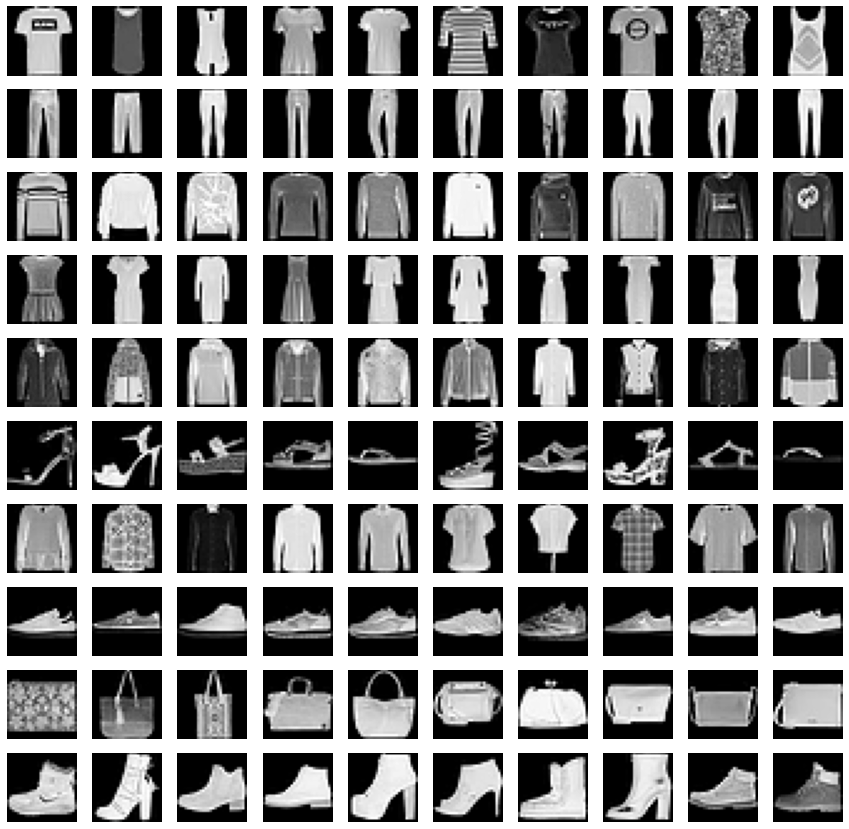

In [9]:
def plot_grid(images, labels, num_classes, num_images_per_class):
    """
    Plot a grid of images of shape num_classes x images_per_class. Each row must 
    contain the images belonging to an unique class.

    Args:
        images: A numpy array of shape (num_classes * images_per_class, data_dimension)
        labels: A numpy array of shape (num_classes * images_per_class,)
        num_classes: The number of classes
        num_images_per_class: The number of images per class to be displayed
    
    Hint: Use plt.subplot to plot the images in a grid.
    """
    # WRITE YOUR CODE HERE
    num_row = num_classes
    num_col = num_images_per_class

    # get a segment of the dataset
    num = num_row*num_col
    

    # plot images
    fig, axes = plt.subplots(num_row, num_col,figsize=(1.5*num_col,1.5*num_row))
    for i in range(num_row):
      mask = (labels == i)
      curr_images = images[mask]
      for j in range(num_col):
        ax = axes[i, j]
        ax.axis('off')
        if j<len(curr_images):
            ax.imshow(curr_images[j].reshape(28,28), cmap='gray')
       
    plt.show()
    
    
plot_grid(train_images, train_labels, num_classes, 10)

# Part B: Principal Component Analysis (PCA)

Principal component analysis (PCA) on the train dataset to reduce the data dimension from `784` to `100`.

In [20]:
def PCA(X , num_components):
    """
    Function to perform PCA on the dataset X.

    Args:
        X: A numpy array of shape (num_samples, data_dimension)
        num_components: The number of principal components to keep

    Returns:
        X_reduced: A numpy array of shape (num_samples, num_components). The represents the reduced data.
        X_reconstructed: A numpy array of shape (num_samples, data_dimension). The represents the reconstructed data from the reduced data.
    """
    # WRITE YOUR CODE HERE
    #Centering
    z = X - np.mean(X)
    #print(np.shape(z))
    cov_matrix = np.cov(z, rowvar = False)
    #Eigen Values and Eigen Vectors
    eigen_values , eigen_vectors = np.linalg.eigh(cov_matrix)
    # sort eigenvectors 
    sorted_idx = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_idx]
    sorted_eigenvectors = eigen_vectors[:,sorted_idx]
    #components
    n_components = 100
    eigenvector_subset = sorted_eigenvectors[:,0:n_components]
    #Transform
    X_reduced = np.dot(eigenvector_subset.transpose(), z.transpose()).transpose()
    #print(np.shape(X_reduced))
    X_reconstructed = np.dot(X_reduced, eigenvector_subset.transpose())
    return X_reduced, X_reconstructed

In [12]:
pca_dimension = 100
train_images_pca, reconstruction = PCA(train_images, pca_dimension)

In [13]:
reconstruction.shape

(1000, 784)

In [14]:
train_images_pca.shape

(1000, 100)

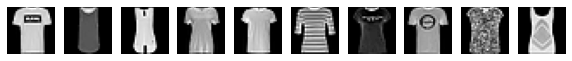

In [15]:
# Visualize the original images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

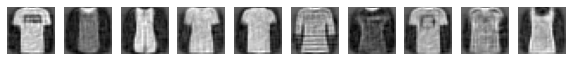

In [16]:
# Visualize the reconstructed images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(reconstruction[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

The reconstructed images look similar to the original input images but are more pixelated due to the dimension reduction.

# Part C: KMeans Clustering

In [21]:
def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).

    Args:
        point: A numpy array of shape (m,)
        data: A numpy array of shape (n,m)

    Returns:
        A numpy array of shape (n,) containing the euclidean distance between point and each row of data.
    """
    dim = len(point)
    result = []
    for d in data:
        s=0
        for x in range(dim):
            s += (point[x]-d[x])**2
        diff = np.sqrt(s)
        result.append(diff)
    res = np.array(result)
    return res

class KMeans:
    """
    Class to perform K-Means clustering.
    """
    def __init__(self, n_clusters=8, max_iter=300):
        """
        Args:
            n_clusters: The number of clusters
            max_iter: The maximum number of iterations to run the algorithm for
        
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    
    def init_centroids(self, X):
        """
        Initialize the centroids by randomly sampling from the dataset. Store the computed
        centroids in self.centroids.

        Args:
            X: A numpy array of shape (num_samples, data_dimension)
        
        Hint: Initialize the centroids such that when a random datapoint is selected as the first, 
              the rest are initialized w/ probabilities proportional to their distances to the first.
              You may use argument `p` in np.random.choice to do this.
        """
        # WRITE YOUR CODE HERE
        self.centroids = []
        first_idx = np.random.choice(range(0,len(X[0])), replace = False, size = 1)
        first = X[first_idx]
        prob = euclidean(first.flatten(), X)
        prob = prob/sum(prob)
        self.centroids = X[np.random.choice(range(0,len(X)), replace = False, size = self.n_clusters-1, p = prob)]
        self.centroids = np.append(self.centroids, first).reshape(10,100)
        
    def fit(self, X_train):
        """
        Train the K-Means model on the dataset X_train.

        Args:
            X_train: A numpy array of shape (num_samples, data_dimension)

        Hint: 
            (1) Use the euclidean function defined above. 
            (2) Run the algorithm for a maximum of self.max_iter iterations.
            (3) Initialize the centroids before running the clustering algorithm.
        """
        # WRITE YOUR CODE HERE
        centroids = KMeans.init_centroids(self, X_train)
        #c=0
        #while c < max_iter:
        #    for x in X_train:
        #        m = np.min(euclidian)
        #    c=c+1
        iteration = 0
        prev = None
        while np.not_equal(centroids, prev).any() and iteration < self.max_iter:
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            prev = centroids
            centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(centroids):
                if np.isnan(centroid).any():
                    centroids[i] = prev[i]
            iteration += 1
            
    def evaluate(self, X):
        """
        Function to evaluate the K-Means model on the dataset X.

        Args:
            X: A numpy array of shape (num_samples, data_dimension)
        
        Returns:
            centroids: A numpy array of shape (n_clusters, data_dimension) containing the centroids of the clusters.
            centroid_idxs: A numpy array of shape (num_samples,) containing the cluster labels for each sample in X.
        """
        centroids, centroid_idxs = [], []
        
        # WRITE YOUR CODE HERE
        for p in X:
            dists = euclidean(p, self.centroids)
            min_dist = np.argmin(dists)
            centroid_idxs.append(min_dist)
            centroids = self.centroids
        return centroids, centroid_idxs

In [22]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(train_images_pca)
# View results
class_centers, classification = kmeans.evaluate(train_images_pca)

### Plot mean image for each cluster

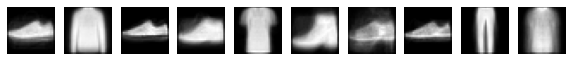

In [25]:
classification_array=np.array(classification)

plt.figure(figsize=(10, 10))
for i in range(10):
    #find index if all classifications equal to i
    class_idx=classification_array==i
    
    #calculate mean image for this class
    mean_image=train_images[classification_array==i].mean(axis=0)
    
    #plot
    plt.subplot(1, 10, i+1)
    plt.imshow(mean_image.reshape(28,28),cmap='gray')
    plt.axis('off')

### Plot grid containing 10 images for each cluster

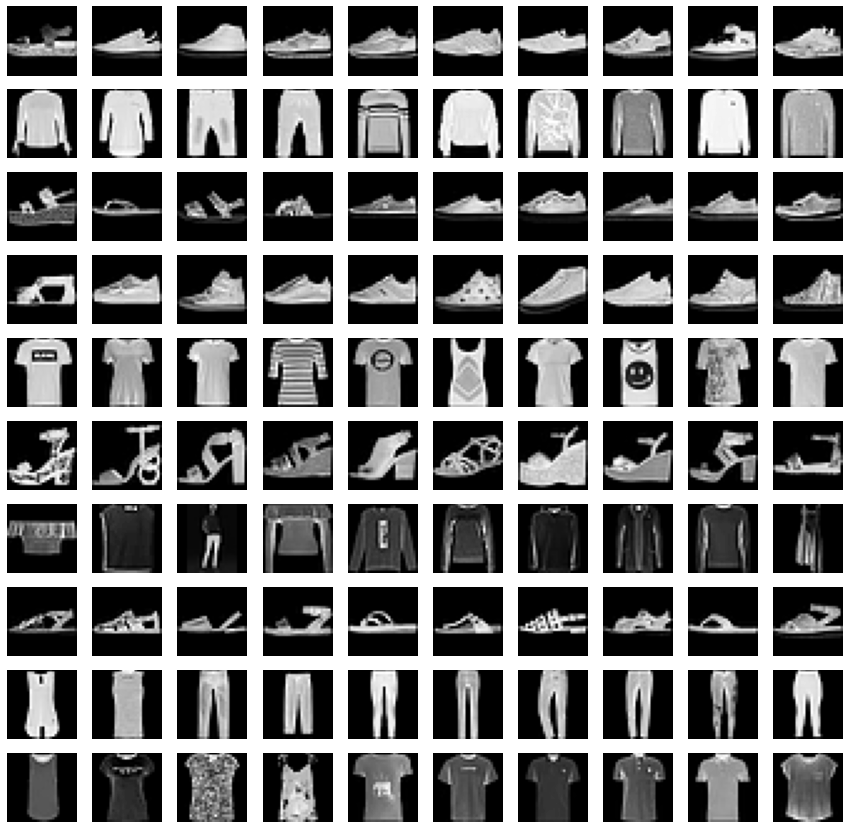

In [26]:
plot_grid(train_images, classification_array, num_classes, 10)

# Extra Credit: k-Nearest Neighbor (KNN) classification (25 points)

In this section, you are supposed to perform k-Nearest Neighbor classification on the test data and find the optimal value of `k` for which the model outputs the highest classification accuracy.

In [27]:
def most_common(lst):
    '''Returns the most common element in a list. If there is a tie, returns the 
    element occuring first in the list.'''
    # WRITE YOUR CODE HERE

    return max(set(lst), key=lst.count)

class KNearestNeighborsClassifier():
    """
    Class to perform K-Nearest Neighbors classification.
    """
    def __init__(self, k=5, dist_metric=euclidean):
        """
        Args:
            k: The number of nearest neighbors to use for classification
            dist_metric: The distance metric to use for classification. (Default: euclidean)
        """
        self.k = k
        self.dist_metric = dist_metric

    def fit(self, X_train, y_train):
        """
        Function to train the K-Nearest Neighbors classifier on the train dataset.

        Args:
            X_train: A numpy array of shape (num_samples, data_dimension) containing the training data.
            y_train: A numpy array of shape (num_samples,) containing the training labels.
        """
        self.X_train = X_train
        self.y_train = y_train       

    def predict(self, X_test):
        """
        Predict the labels for the test dataset.

        Args:
            X_test: A numpy array of shape (num_samples, data_dimension) containing the test data.

        Returns:
            y_pred: A numpy array of shape (num_samples,) containing the predicted labels for the test data.

        Hint: Use the self.dist_metric function to compute the distance between the test data and the training data.
              For each sample, choose the most common label among the k nearest neighbors.
        """
        # WRITE YOUR CODE HERE

        neighbors = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])
        return list(map(most_common, neighbors))
    
    def evaluate(self, X_test, y_test):
        """
        Evaluate the K-Nearest Neighbors classifier on the test dataset.

        Args:
            X_test: A numpy array of shape (num_samples, data_dimension) containing the test data.
            y_test: A numpy array of shape (num_samples,) containing the test labels.

        Returns:
            accuracy: A float value between 0 and 1 representing the accuracy of the classifier.
        """
        # WRITE YOUR CODE HERE
        
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy

In [ ]:
# Evaluate KNN classifier for k varying from 1 to 30 and plot the accuracy
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNearestNeighborsClassifier(k=k)
    knn.fit(train_images, train_labels)
    accuracy = knn.evaluate(test_images, test_labels)
    accuracies.append(accuracy)
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()